# Compare errors in IC2 to errors in A3D
1. First plot A3D vs observed SMB
2. Then get IC2 and ATM elevation along that transect

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import xarray as xr
from osgeo import osr
import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from calendar import monthrange
from scipy import stats

## Load observed SMB from Dattler et. al., 2019

In [2]:
obs_lat, obs_lon, obs_accumulation, relative_accumulation, relative_accumulation_error = \
    np.loadtxt("/pl/active/nasa_smb/Data/Accumulation_Data_Product.csv", skiprows=1, delimiter=',', unpack=True)

# Transform obs lat/lon into epsg 3031

In [3]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
obs_X = np.zeros(len(obs_lon)); obs_X[:] = np.nan
obs_Y = np.zeros(len(obs_lon)); obs_Y[:] = np.nan

# Perform transformation
for j in range(0, len(obs_X)):
    coords = transform.TransformPoint(obs_lat[j], obs_lon[j]) # Lat, Lon
    obs_X[j], obs_Y[j] = coords[0:2]

# Load A3D

In [4]:
path = "../../nc_storage/latest_wn_PBC.nc"
ds = xr.open_dataset(path)
ds = ds.isel(easting=slice(15, -15))
ds = ds.isel(northing=slice(15, -15))
ds

<xarray.Dataset>
Dimensions:                (easting: 168, northing: 107, time: 8783)
Coordinates:
  * time                   (time) datetime64[ns] 1980-01-01T01:00:00 ... 1980-12-31T23:00:00
  * northing               (northing) float32 -108500.0 -107500.0 ... -2500.0
  * easting                (easting) float32 -1542500.0 ... -1375500.0
Data variables:
    dw                     (time, northing, easting) float32 ...
    ERODEDMASS             (time, northing, easting) float32 ...
    ET                     (time, northing, easting) float32 ...
    snd                    (time, northing, easting) float32 ...
    rlds                   (time, northing, easting) float32 ...
    rsds                   (time, northing, easting) float32 ...
    MS_HNW                 (time, northing, easting) float32 ...
    MS_SNOWPACK_RUNOFF     (time, northing, easting) float32 ...
    MS_WIND                (time, northing, easting) float32 ...
    pr                     (time, northing, easting) float32 ...
    hur                    (time, northing, easting) float32 ...
    RHO1                   (time, northing, easting) float32 ...
    RHO2                   (time, northing, easting) float32 ...
    RHO3                   (time, northing, easting) float32 ...
    RHO4                   (time, northing, easting) float32 ...
    RHO5                   (time, northing, easting) float32 ...
    SFC_SUBL               (time, northing, easting) float32 ...
    SURF_ALB               (time, northing, easting) float32 ...
    swe                    (time, northing, easting) float32 ...
    ta                     (time, northing, easting) float32 ...
    ts                     (time, northing, easting) float32 ...
    ws                     (time, northing, easting) float32 ...
    WINDEROSIONDEPOSITION  (time, northing, easting) float32 ...
Attributes:
    date_created:              2021-10-23
    creator_name:              erke2265
    source:                    MeteoIO-3.00
    history:                   2021-10-24T03:39:44Z, erke2265@shas0653.rc.int...
    keywords_vocabulary:       AGU Index Terms
    keywords:                  Cryosphere, Mass Balance, Energy Balance, Atmo...
    title:                     Gridded data for various parameters and timesteps
    institution:               colorado.edu
    product_version:           1.0
    Conventions:               CF-1.6,ACDD-1.3
    standard_name_vocabulary:  CF-1.6
    cdm_data_type:             Grid
    geospatial_bounds_crs:     EPSG:3031
    geospatial_bounds:         Polygon ((-1557500.0000000000 -123500.00000000...

In [5]:
domain_left = ds['easting'].min()
domain_right = ds['easting'].max()
domain_bottom = ds['northing'].min()
domain_top = ds['northing'].max()

In [6]:
# Function to get indices of observations inside of the model domain
def get_domain_obs(obsX, obsY, obs_accum, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon):
    '''
    Find obs whose X and Y are:
        X: greater than domain_left and less than domain_right
        Y: greater than domain_bottom and less than domain_top
    ''' 
    filter_func = np.vectorize(lambda obsX, obsY: obsX <= domain_right and obsX >= domain_left and obsY >= domain_bottom and obsY <= domain_top)
    indices = filter_func(obsX, obsY)
    obs_accum_filter = obs_accum[indices]
    obsX_filter = obsX[indices]
    obsY_filter = obsY[indices]
    obs_lat_filter = obs_lat[indices]
    obs_lon_filter = obs_lon[indices]
    
    return obsX_filter, obsY_filter, obs_accum_filter, obs_lat_filter, obs_lon_filter

# # Retrieve observations
obs_X, obs_Y, obs_accumulation, obs_lat, obs_lon = get_domain_obs(obs_X, obs_Y, obs_accumulation, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon)

In [7]:
tgt_x = xr.DataArray(obs_X, dims="points")
tgt_y = xr.DataArray(obs_Y, dims="points")

SNOWPACK_SMB = ds['swe'].isel(time=-1) - ds['swe'].isel(time=0)
SNOWPACK_SMB = 1000 * SNOWPACK_SMB.sel(northing=tgt_y, easting=tgt_x, method='nearest')

In [8]:
# Indices to plot
ind0 = 660 # I've typically done 1000:2000
indf = 2000
indices = np.arange(ind0, indf)

In [9]:
# Calculate distance along track (dat)
dat = np.zeros(len(indices)); dat[:] = np.nan
x0 = obs_X[ind0]; y0 = obs_Y[ind0]
count = -1 # Add hock index counter 

for j in range(ind0, indf):
    count = count + 1
    dat[count] = np.sqrt(np.square(obs_X[j] - x0) + np.square(obs_Y[j] - y0)) / 1000

# IC2 along the transect

In [10]:
# load data
IC2_path = "../input/surface-grids/dem.asc"
IC2_z = np.loadtxt(IC2_path, skiprows=6)

# Define corners and easting/northings
x_min = -1557500
x_max = x_min + (198 - 1) * 1000
y_min = -123500
y_max = y_min + (137 - 1) * 1000
X = np.linspace(x_min, x_max, 198)
Y = np.linspace(y_min, y_max, 137)

# Create xarray object
IC2_elevation = xr.DataArray(np.flipud(IC2_z), name="elevation", coords=[Y, X], dims=["northing", "easting"])
IC2_Z_transect = IC2_elevation.sel(northing=tgt_y, easting=tgt_x, method='nearest')

# REMA along the transect

In [11]:
# load data
REMA_path = "/scratch/summit/erke2265/REMA/REMA_1km.asc"
REMA_z = np.loadtxt(REMA_path, skiprows=6)

# Define corners and easting/northings
x_min = -1557000
x_max = x_min + (198 - 1) * 1000
y_min = -124000
y_max = y_min + (137 - 1) * 1000
X = np.linspace(x_min, x_max, 198)
Y = np.linspace(y_min, y_max, 137)

# Create xarray object
REMA_elevation = xr.DataArray(np.flipud(REMA_z), name="elevation", coords=[Y, X], dims=["northing", "easting"])
REMA_Z_transect = REMA_elevation.sel(northing=tgt_y, easting=tgt_x, method='nearest')

# Load ATM along the transect

In [12]:
# Load ATM data
atm_path = "/pl/active/nasa_smb/Data/ATM_20161109.txt"
atm_lat, atm_lon, atm_z = np.loadtxt(atm_path, delimiter=",", skiprows=1, usecols=(1,2,3), unpack=True)

# Convert to xarray object
atm_elevation = xr.DataArray(atm_z, name="elevation", coords=[atm_lat], dims=["lat"])
atm_elevation = atm_elevation.assign_coords(lon=("lat", atm_lon))
atm_elevation

<xarray.DataArray 'elevation' (lat: 250015)>
array([198.319 , 190.2892, 186.4853, ..., -30.8759, -30.7447, -30.865 ])
Coordinates:
  * lat      (lat) float64 -73.07 -73.07 -73.07 -73.07 ... -74.46 -74.46 -74.46
    lon      (lat) float64 270.2 270.2 270.2 270.2 ... 254.7 254.7 254.7 254.7

In [13]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
atm_X = np.zeros(len(atm_elevation)); atm_X[:] = np.nan
atm_Y = np.zeros(len(atm_elevation)); atm_Y[:] = np.nan
atm_lat = atm_elevation['lat'].values
atm_lon = atm_elevation['lon'].values

# Perform transformation
for j in range(0, len(atm_X)):
    coords = transform.TransformPoint(atm_lat[j], atm_lon[j]) # Lat, Lon
    atm_X[j], atm_Y[j] = coords[0:2]

# Add easting and northings to dataset 
atm_elevation = atm_elevation.assign_coords(easting=("lat", atm_X))
atm_elevation = atm_elevation.assign_coords(northing=("lat", atm_Y))
atm_elevation

<xarray.DataArray 'elevation' (lat: 250015)>
array([198.319 , 190.2892, 186.4853, ..., -30.8759, -30.7447, -30.865 ])
Coordinates:
  * lat       (lat) float64 -73.07 -73.07 -73.07 -73.07 ... -74.46 -74.46 -74.46
    lon       (lat) float64 270.2 270.2 270.2 270.2 ... 254.7 254.7 254.7 254.7
    easting   (lat) float64 -1.852e+06 -1.852e+06 ... -1.638e+06 -1.638e+06
    northing  (lat) float64 5.265e+03 5.415e+03 ... -4.478e+05 -4.479e+05

In [14]:
# Loop over each observational SMB point and find the nearest ATM point
ATM_Z_transect = np.zeros(len(indices))
for j in range(0, len(indices)):
# for j in range(0, 3):
#     print(j)
    tgt_X = obs_X[indices[j]]
    tgt_Y = obs_Y[indices[j]]
#     print(tgt_X)
#     print(tgt_Y)
    
    x_diff = tgt_X - atm_elevation['easting'].values
    y_diff = tgt_Y - atm_elevation['northing'].values
    distance = np.sqrt(x_diff**2 + y_diff**2)
#     print(distance.min())
#     print(distance.argmin())
#     print(atm_elevation[distance.argmin()].values)
    ATM_Z_transect[j] = atm_elevation[distance.argmin()].values
#     print()

# Plot

In [15]:
snowpack_factor = 1000*obs_accumulation[indices].mean() / SNOWPACK_SMB[indices].mean()
print(snowpack_factor)

a3d_error = snowpack_factor*SNOWPACK_SMB[indices] - 1000*obs_accumulation[indices]
IC2_error = IC2_Z_transect[indices] - ATM_Z_transect
REMA_error = REMA_Z_transect[indices] - ATM_Z_transect

<xarray.DataArray 'swe' ()>
array(1.37470861)


<xarray.DataArray 'swe' ()>
array(1.37470861)


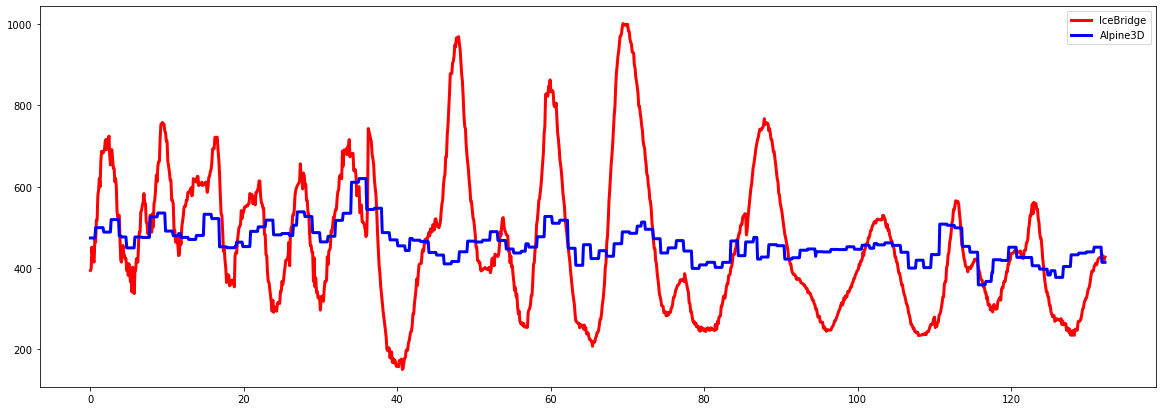

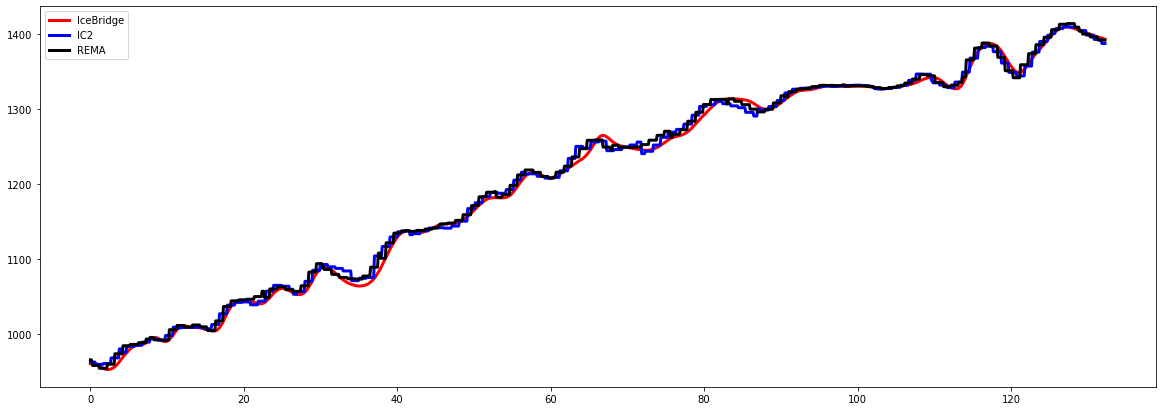

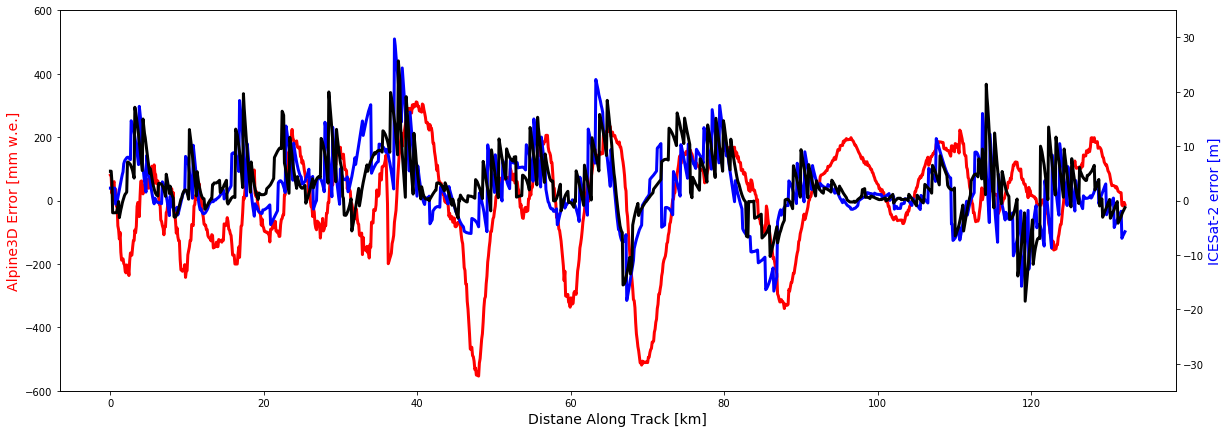

In [16]:
snowpack_factor = 1000*obs_accumulation[indices].mean() / SNOWPACK_SMB[indices].mean()
print(snowpack_factor)
fig, ax1 = plt.subplots(figsize=(20,7))
plt.plot(dat, 1000*obs_accumulation[indices], 'r', label='IceBridge', linewidth=3)
plt.plot(dat, snowpack_factor*SNOWPACK_SMB[indices], 'b', label='Alpine3D', linewidth=3)
plt.legend()

fig, ax1 = plt.subplots(figsize=(20,7))
plt.plot(dat, ATM_Z_transect, 'r', label='IceBridge', linewidth=3)
plt.plot(dat, IC2_Z_transect[indices], 'b', label='IC2', linewidth=3)
plt.plot(dat, REMA_Z_transect[indices], 'k', label='REMA', linewidth=3)
plt.legend()

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(20, 7))
ax.plot(dat, a3d_error, color="red", linewidth=3)
ax.set_xlabel("Distane Along Track [km]",fontsize=14)
ax.set_ylabel("Alpine3D Error [mm w.e.]",color="red",fontsize=14)
ax.set_ylim([-600, 600])

ax2=ax.twinx()
ax2.plot(dat, IC2_error, color="blue", linewidth=3)
ax2.plot(dat, REMA_error, color="black", linewidth=3)
ax2.set_ylabel("ICESat-2 error [m]",color="blue",fontsize=14)
ax2.set_ylim([-35, 35])
plt.show()

(-30, 30)

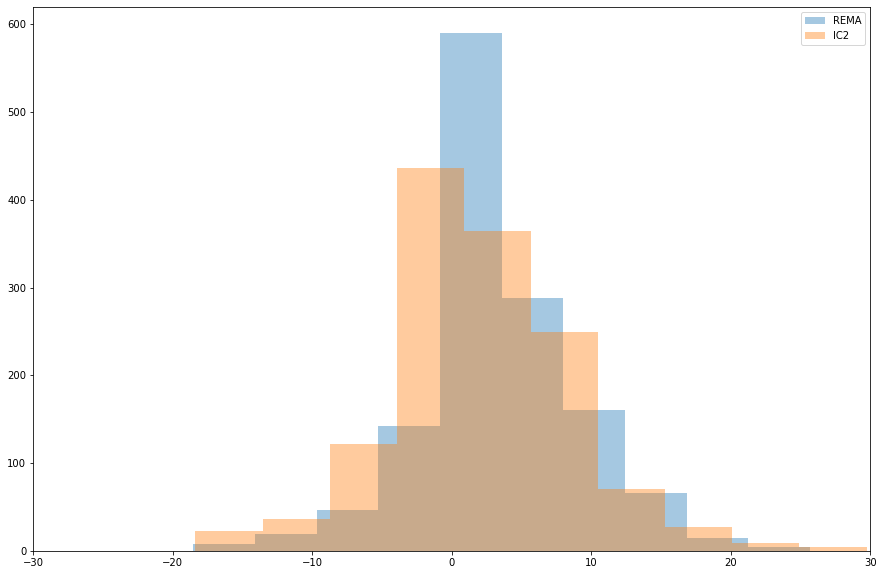

In [17]:
plt.figure(figsize=(15, 10)) 
plt.hist(REMA_error, label='REMA', alpha=0.4)
plt.hist(IC2_error, label='IC2', alpha=0.4)
plt.legend()
plt.xlim([-30, 30])

In [20]:
print("REMA:")
print(REMA_error.mean())
print(REMA_error.std())
print()
print("IC2:")
print(IC2_error.mean())
print(IC2_error.std())

REMA:
<xarray.DataArray 'elevation' ()>
array(3.13757951)
<xarray.DataArray 'elevation' ()>
array(5.6255885)

IC2:
<xarray.DataArray 'elevation' ()>
array(2.1270801)
<xarray.DataArray 'elevation' ()>
array(6.43919169)
